In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_x.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_mask.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_x.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5


In [2]:
# ===== 0) Imports & Setup =====
import os
import math
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import torch.cuda.amp as amp

# Reproducibility
SEED = 1131
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



# Paths from Kaggle environment (updated for standard PCam dataset)
BASE_DIR = "/kaggle/input/pcamv1/pcamv1/"
TRAIN_X_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5")
TRAIN_Y_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_train_y.h5")
VALID_X_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_valid_x.h5")
VALID_Y_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_valid_y.h5")
TEST_X_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_test_x.h5")
TEST_Y_PATH = os.path.join(BASE_DIR, "camelyonpatch_level_2_split_test_y.h5")

# Verify paths
for path in [TRAIN_X_PATH, TRAIN_Y_PATH, VALID_X_PATH, VALID_Y_PATH, TEST_X_PATH, TEST_Y_PATH]:
    if not os.path.exists(path):
        print(f"File not found: {path}")
    else:
        print(f"File found: {path}")

# Training hyperparameters
INPUT_SIZE = 128  # Paper uses 128x128
BATCH_SIZE = 128  # Adjust if OOM (64 or 96 safer)
WARMUP_EPOCHS = 3
FINETUNE_EPOCHS = 3
LR_WARMUP = 1e-3
LR_FINETUNE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Mixed precision
try:
    from torch.amp import autocast, GradScaler  # Updated import
    MIXED_PRECISION = True
    print("Mixed precision enabled")
except:
    MIXED_PRECISION = False
    print("Mixed precision not available")

File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5
File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5
File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_x.h5
File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_y.h5
File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_x.h5
File found: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_y.h5
Using device: cuda
Mixed precision enabled


In [3]:
# Training hyperparameters
INPUT_SIZE = 128  # Paper uses 128x128
BATCH_SIZE = 64 # Adjust if OOM (64 or 96 safer)
WARMUP_EPOCHS = 3
FINETUNE_EPOCHS = 12
LR_WARMUP = 1e-3
LR_FINETUNE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Mixed precision
try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION = True
    print("Mixed precision enabled")
except:
    MIXED_PRECISION = False
    print("Mixed precision not available")

# ===== 1) HDF5 Dataset =====
class PCamH5Dataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        self.x_file = h5py.File(x_path, "r")
        self.y_file = h5py.File(y_path, "r")
        self.X = self.x_file["x"]  # (N, 96, 96, 3) uint8
        self.Y = self.y_file["y"]  # (N, 1, 1, 1)
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Load image and label
        img = self.X[idx].astype(np.float32) / 255.0  # Normalize to [0,1]
        label = float(self.Y[idx].reshape(-1)[0])
        
        # Convert to torch tensor (H,W,C -> C,H,W)
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3, 96, 96)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def close(self):
        self.x_file.close()
        self.y_file.close()

# Data augmentation (as per paper)
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=15),
    transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.85, 1.0)),
])

valid_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
])

# Create datasets
train_dataset = PCamH5Dataset(TRAIN_X_PATH, TRAIN_Y_PATH, transform=train_transform)
valid_dataset = PCamH5Dataset(VALID_X_PATH, VALID_Y_PATH, transform=valid_transform)
test_dataset = PCamH5Dataset(TEST_X_PATH, TEST_Y_PATH, transform=valid_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Compute class weights
def count_class_distribution(y_path, chunk=65536):
    f = h5py.File(y_path, "r")
    Y = f["y"]
    n = Y.shape[0]
    ones = 0
    for start in range(0, n, chunk):
        end = min(start + chunk, n)
        ones += Y[start:end].reshape(-1).sum()
    zeros = n - int(ones)
    f.close()
    return zeros, int(ones)

neg, pos = count_class_distribution(TRAIN_Y_PATH)
print(f"Train label counts → 0: {neg}, 1: {pos}")
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.array([0] * neg + [1] * pos))
class_weight_dict = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weight_dict)

# Convert class weights to tensor for loss
class_weights_tensor = torch.tensor([class_weight_dict[0], class_weight_dict[1]], dtype=torch.float32).to(DEVICE)

Using device: cuda
Mixed precision enabled
Train label counts → 0: 131072, 1: 131072
Class weights: {0: 1.0, 1: 1.0}


In [4]:
# ===== 1) HDF5 Dataset =====
class PCamH5Dataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        self.x_file = h5py.File(x_path, "r")
        self.y_file = h5py.File(y_path, "r")
        self.X = self.x_file["x"]  # (N, 96, 96, 3) uint8
        self.Y = self.y_file["y"]  # (N, 1, 1, 1)
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img = self.X[idx].astype(np.float32) / 255.0  # Normalize to [0,1]
        label = float(self.Y[idx].reshape(-1)[0])
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3, 96, 96)
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, label

    def close(self):
        self.x_file.close()
        self.y_file.close()

# Data augmentation (as per paper)
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=15),
    transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.85, 1.0)),
])

valid_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
])

# Create datasets
train_dataset = PCamH5Dataset(TRAIN_X_PATH, TRAIN_Y_PATH, transform=train_transform)
valid_dataset = PCamH5Dataset(VALID_X_PATH, VALID_Y_PATH, transform=valid_transform)
test_dataset = PCamH5Dataset(TEST_X_PATH, TEST_Y_PATH, transform=valid_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Compute class weights
def count_class_distribution(y_path, chunk=65536):
    f = h5py.File(y_path, "r")
    Y = f["y"]
    n = Y.shape[0]
    ones = 0
    for start in range(0, n, chunk):
        end = min(start + chunk, n)
        ones += Y[start:end].reshape(-1).sum()
    zeros = n - int(ones)
    f.close()
    return zeros, int(ones)

neg, pos = count_class_distribution(TRAIN_Y_PATH)
print(f"Train label counts → 0: {neg}, 1: {pos}")
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.array([0] * neg + [1] * pos))
class_weight_dict = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weight_dict)

class_weights_tensor = torch.tensor([class_weight_dict[0], class_weight_dict[1]], dtype=torch.float32).to(DEVICE)

Train label counts → 0: 131072, 1: 131072
Class weights: {0: 1.0, 1: 1.0}


In [5]:
# ===== 2) Model Definition =====
class DNBCD(nn.Module):
    def __init__(self):
        super(DNBCD, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 256)
        self.bn = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)  # Output raw logits

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Initialize model
model = DNBCD().to(DEVICE)

# Freeze backbone for warmup
for param in model.backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 202MB/s]


In [6]:
# ===== 3) Training Setup =====
criterion = nn.BCEWithLogitsLoss(reduction='none')  # For logits + per-sample weighting
optimizer = optim.AdamW(model.parameters(), lr=LR_WARMUP)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scaler = GradScaler() if MIXED_PRECISION else None
best_auc = 0.0
ckpt_path = "/kaggle/working/dnbcd_pcam_best.pth"


def train_epoch(loader, model, criterion, optimizer, scaler, class_weights_tensor):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    all_probs, all_labels = [], []
    
    progress_bar = tqdm(loader, desc="Training")
    
    for images, labels in progress_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE).float()
        
        optimizer.zero_grad()
        
        if MIXED_PRECISION:
            # Fixed autocast usage
            with torch.cuda.amp.autocast():
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                # Apply class weights
                weights = class_weights_tensor[labels.long()]
                loss = (loss * weights).mean()
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights_tensor[labels.long()]
            loss = (loss * weights).mean()
        
        if MIXED_PRECISION:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        all_probs.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    accuracy = total_correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy, auc

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_36/253108213.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if MIXED_PRECISION else None


In [7]:
import torch
print(torch.__version__)

2.6.0+cu124


In [8]:
def validate_epoch(loader, model, criterion, class_weights_tensor):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation")
        
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float()
            
            if MIXED_PRECISION:
                # Fixed autocast usage
                with torch.cuda.amp.autocast():
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, labels)
                    weights = class_weights_tensor[labels.long()]
                    loss = (loss * weights).mean()
            else:
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                weights = class_weights_tensor[labels.long()]
                loss = (loss * weights).mean()
            
            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_probs.extend(torch.sigmoid(outputs).cpu().detach().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    accuracy = total_correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy, auc

In [9]:
# ===== 4) Training Loop =====
print("Starting warm-up training phase...")
history = {'train_loss': [], 'train_acc': [], 'train_auc': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

for epoch in range(WARMUP_EPOCHS):
    train_loss, train_acc, train_auc = train_epoch(train_loader, model, criterion, optimizer, scaler, class_weights_tensor)
    val_loss, val_acc, val_auc = validate_epoch(valid_loader, model, criterion, class_weights_tensor)
    
    print(f"Epoch {epoch+1}/{WARMUP_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    scheduler.step(val_auc)
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), ckpt_path)
        print(f"Saved best model with AUC {best_auc:.4f}")

# Fine-tuning phase
print("Starting fine-tuning phase...")
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=LR_FINETUNE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

for epoch in range(FINETUNE_EPOCHS):
    train_loss, train_acc, train_auc = train_epoch(train_loader, model, criterion, optimizer, scaler, class_weights_tensor)
    val_loss, val_acc, val_auc = validate_epoch(valid_loader, model, criterion, class_weights_tensor)
    
    print(f"Epoch {epoch+1}/{FINETUNE_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    scheduler.step(val_auc)
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), ckpt_path)
        print(f"Saved best model with AUC {best_auc:.4f}")

print(f"Training completed! Best validation AUC: {best_auc:.4f}")

Starting warm-up training phase...


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:38<00:00, 13.15it/s, loss=0.4706]


Epoch 1/3
Train Loss: 0.3957, Acc: 0.8204, AUC: 0.9018
Val Loss: 0.3894, Acc: 0.8209, AUC: 0.9121
Saved best model with AUC 0.9121


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.18it/s, loss=0.4858]


Epoch 2/3
Train Loss: 0.3676, Acc: 0.8358, AUC: 0.9160
Val Loss: 0.3837, Acc: 0.8166, AUC: 0.9139
Saved best model with AUC 0.9139


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.23it/s, loss=0.5459]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/3
Train Loss: 0.3569, Acc: 0.8417, AUC: 0.9211
Val Loss: 0.4006, Acc: 0.8176, AUC: 0.9114
Starting fine-tuning phase...


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.13it/s, loss=0.5920]


Epoch 1/12
Train Loss: 0.1902, Acc: 0.9268, AUC: 0.9772
Val Loss: 0.3587, Acc: 0.8726, AUC: 0.9588
Saved best model with AUC 0.9588


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.02it/s, loss=0.6395]


Epoch 2/12
Train Loss: 0.1354, Acc: 0.9504, AUC: 0.9879
Val Loss: 0.4200, Acc: 0.8844, AUC: 0.9495


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:32<00:00, 15.96it/s, loss=0.5382]


Epoch 3/12
Train Loss: 0.1171, Acc: 0.9580, AUC: 0.9908
Val Loss: 0.3362, Acc: 0.9022, AUC: 0.9568


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.16it/s, loss=0.4729]


Epoch 4/12
Train Loss: 0.1046, Acc: 0.9625, AUC: 0.9925
Val Loss: 0.4078, Acc: 0.8871, AUC: 0.9590
Saved best model with AUC 0.9590


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.16it/s, loss=0.6408]


Epoch 5/12
Train Loss: 0.0966, Acc: 0.9659, AUC: 0.9935
Val Loss: 0.4637, Acc: 0.8751, AUC: 0.9532


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.19it/s, loss=1.2298]


Epoch 6/12
Train Loss: 0.0891, Acc: 0.9685, AUC: 0.9945
Val Loss: 0.7756, Acc: 0.8146, AUC: 0.9263


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.13it/s, loss=0.6071]


Epoch 7/12
Train Loss: 0.0832, Acc: 0.9707, AUC: 0.9952
Val Loss: 0.4424, Acc: 0.8777, AUC: 0.9588


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.20it/s, loss=0.8321]


Epoch 8/12
Train Loss: 0.0662, Acc: 0.9773, AUC: 0.9968
Val Loss: 0.5909, Acc: 0.8559, AUC: 0.9502


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.05it/s, loss=0.6594]


Epoch 9/12
Train Loss: 0.0612, Acc: 0.9787, AUC: 0.9973
Val Loss: 0.5502, Acc: 0.8639, AUC: 0.9529


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.21it/s, loss=0.7426]


Epoch 10/12
Train Loss: 0.0571, Acc: 0.9801, AUC: 0.9977
Val Loss: 0.5738, Acc: 0.8566, AUC: 0.9551


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:31<00:00, 16.20it/s, loss=0.9860]


Epoch 11/12
Train Loss: 0.0495, Acc: 0.9831, AUC: 0.9982
Val Loss: 0.7018, Acc: 0.8554, AUC: 0.9503


Training:   0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_36/253108213.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:32<00:00, 15.86it/s, loss=0.7312]


Epoch 12/12
Train Loss: 0.0457, Acc: 0.9843, AUC: 0.9985
Val Loss: 0.6322, Acc: 0.8559, AUC: 0.9538
Training completed! Best validation AUC: 0.9590


Loading best model for evaluation...


Validation:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/3833274556.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 512/512 [00:32<00:00, 15.99it/s, loss=0.6081]


Test Loss: 0.5365, Acc: 0.8318, AUC: 0.9517
Generating detailed predictions...


Testing:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_36/2213094267.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Correct way
Testing: 100%|██████████| 512/512 [00:30<00:00, 16.57it/s]



Classification Report:
               precision    recall  f1-score   support

No Metastasis       0.76      0.98      0.85     16391
   Metastasis       0.97      0.68      0.80     16377

     accuracy                           0.83     32768
    macro avg       0.86      0.83      0.83     32768
 weighted avg       0.86      0.83      0.83     32768



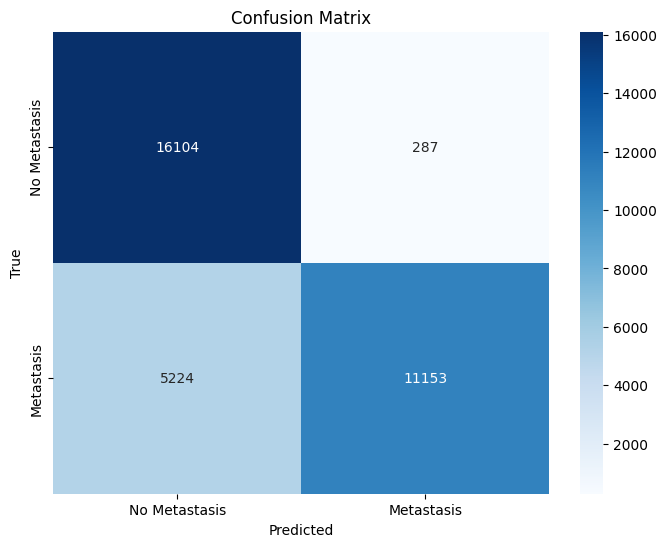

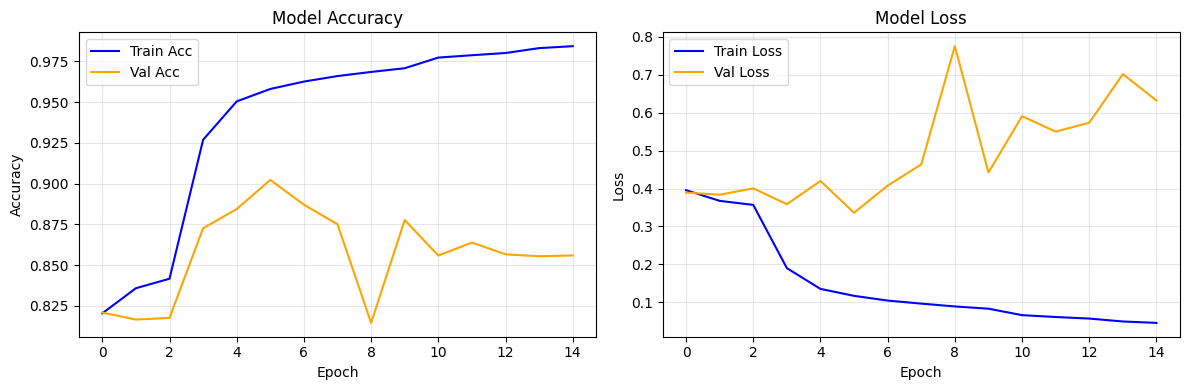


Additional Metrics:
AUC-ROC Score: 0.9517

Threshold Analysis:
Threshold 0.3: Accuracy = 0.8547
Threshold 0.4: Accuracy = 0.8441
Threshold 0.5: Accuracy = 0.8318
Threshold 0.6: Accuracy = 0.8205
Threshold 0.7: Accuracy = 0.8063

Cleaning up...
✅ Training and evaluation completed!
Results saved to training_results.json


In [12]:

# ===== 5) Evaluation =====
print("Loading best model for evaluation...")
model.load_state_dict(torch.load(ckpt_path))
model.eval()

# Test evaluation
test_loss, test_acc, test_auc = validate_epoch(test_loader, model, criterion, class_weights_tensor)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

# Detailed metrics
print("Generating detailed predictions...")
preds, trues = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(DEVICE)
        
        # Fixed autocast usage
        if MIXED_PRECISION:
            with torch.cuda.amp.autocast():  # Correct way
                outputs = model(images).squeeze()
        else:
            outputs = model(images).squeeze()
        
        preds.extend(torch.sigmoid(outputs).cpu().numpy())  # Apply sigmoid for metrics
        trues.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(
    trues, 
    (np.array(preds) > 0.5).astype(int), 
    target_names=['No Metastasis', 'Metastasis']
))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(trues, (np.array(preds) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Metastasis', 'Metastasis'], 
            yticklabels=['No Metastasis', 'Metastasis'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc', color='blue')
plt.plot(history['val_acc'], label='Val Acc', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional metrics
print(f"\nAdditional Metrics:")
print(f"AUC-ROC Score: {roc_auc_score(trues, preds):.4f}")

# Threshold analysis
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nThreshold Analysis:")
for thresh in thresholds:
    pred_binary = (np.array(preds) > thresh).astype(int)
    acc = (pred_binary == np.array(trues)).mean()
    print(f"Threshold {thresh}: Accuracy = {acc:.4f}")

# Clean up datasets
print("\nCleaning up...")
if hasattr(train_dataset, 'close'):
    train_dataset.close()
if hasattr(valid_dataset, 'close'):
    valid_dataset.close()
if hasattr(test_dataset, 'close'):
    test_dataset.close()

print("✅ Training and evaluation completed!")

# Optional: Save final results
results_summary = {
    'best_validation_auc': best_auc,
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_auc': test_auc,
    'training_history': history
}

# Save results to file
import json
with open('/kaggle/working/training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to training_results.json")